Load the libraries

In [ ]:
libraries <- c(
    'tidyverse', 'seqinr', 'ggtree',
    'ape', 'circlize', 'phangorn',
    'Biostrings', 'lmtest', 'igraph',
    'dplyr', 'UpSetR', 'scales', 
    'patchwork', 'ggraph'
)
lapply(libraries, library, character.only = TRUE)

In [2]:
setwd("~/hbv_covar3")
genotypes <- c("A", "B", "C", "D")
genes <- c("C", "P", "S", "X")
potential_ovp_threshold <- 0

# input file
tree_files <- paste0("./analysis/phylo_build/RAxML_bestTree.HBV", genotypes, "_rooted")
names(tree_files) <- genotypes

allele_switch_files <- paste0("./analysis/hbv", genotypes, "_allele_switch_cnt.rds")
names(allele_switch_files) <- genotypes

gene_msa_files <- map(genes, function(x) {
    paste0("./amino_acid/HBV_gene", x, "_AAseqs_noShift_stopToDot_mafft.fasta")
})
names(gene_msa_files) <- genest

per_site_hmp_files <- paste0("./analysis/hbv", genotypes, "_per_site_hmp_woOvp.rds")
names(per_site_hmp_files) <- genotypes

assoc_files <- paste0("./analysis/hbv", genotypes, "_lasso_nofuse_pair_extraInfo_mspval_hmp_domain.tsv")
names(assoc_files) <- genotypes

gene_aa_to_wg_pos_files <- paste0("./analysis/hbv", genotypes, "_gene_aa_to_genome_pos_perSamp.rds")
names(gene_aa_to_wg_pos_files) <- genotypes

gene_msa_pos_file <- "./QC/step4_translate_gene/gene_msa_pos.rds"

# load data
message("loading tree files...")
trees <- map(tree_files, read.tree)
names(trees) <- genotypes

message("loading switch files...")
allele_switchs <- map(allele_switch_files, readRDS)
names(allele_switchs) <- genotypes

message("loading gene msa files...")
gene_msa <- map(genes, function(x) {
    do.call(rbind, read.fasta(gene_msa_files[[x]]))
})
names(gene_msa) <- genes

message("loading association files...")
assocs <- map(assoc_files, function(x) {
    read.table(x, header = T, stringsAsFactors = F)
})
names(assocs) <- genotypes

message("loading amino acid to wg position files...")
gene_aa_to_wg_pos <- map(gene_aa_to_wg_pos_files, readRDS)
names(gene_aa_to_wg_pos) <- genotypes

message("loading gene location file...")
gene_msa_pos <- readRDS(gene_msa_pos_file)

message("loading per site hmp file...")
per_site_hmp <- map(per_site_hmp_files, readRDS)
names(per_site_hmp_files) <- genotypes

loading tree files...

loading switch files...

loading gene msa files...

loading association files...

loading amino acid to wg position files...

loading gene location file...

loading per site hmp file...



In [13]:
### build domain dict
domain_pos_file <- "./analysis/protein_domain_pos_aa.rds"
domain_pos <- readRDS(domain_pos_file)[[genotype]]
domain_pos <- map(domain_pos, function(x) do.call(cbind, x))
domain_dict <- list()
for (gene in genes){
    gene_cons <- seqinr::consensus(gene_msa[[gene]])
    gene_pos <- 1:length(gene_cons)
    for (i in 1:ncol(domain_pos[[gene]])){
        cur_dom <- colnames(domain_pos[[gene]])[i]
        dom_start <- domain_pos[[gene]][1, i]
        dom_end <- domain_pos[[gene]][2, i]
        cur_dom_cons <- gene_cons[dom_start:dom_end]
        cur_dom_pos <- gene_pos[dom_start:dom_end]
        cur_dom_nogap_pos <- cur_dom_pos[-which(cur_dom_cons == "-")]
        for (pos in dom_start:dom_end) {
            site_id <- paste0("gene", gene, "_site", pos)
            dom_nogap_pos <- which(cur_dom_nogap_pos == pos)
            domain_dict[[site_id]] <- c(cur_dom, dom_nogap_pos)
        }
    }
}

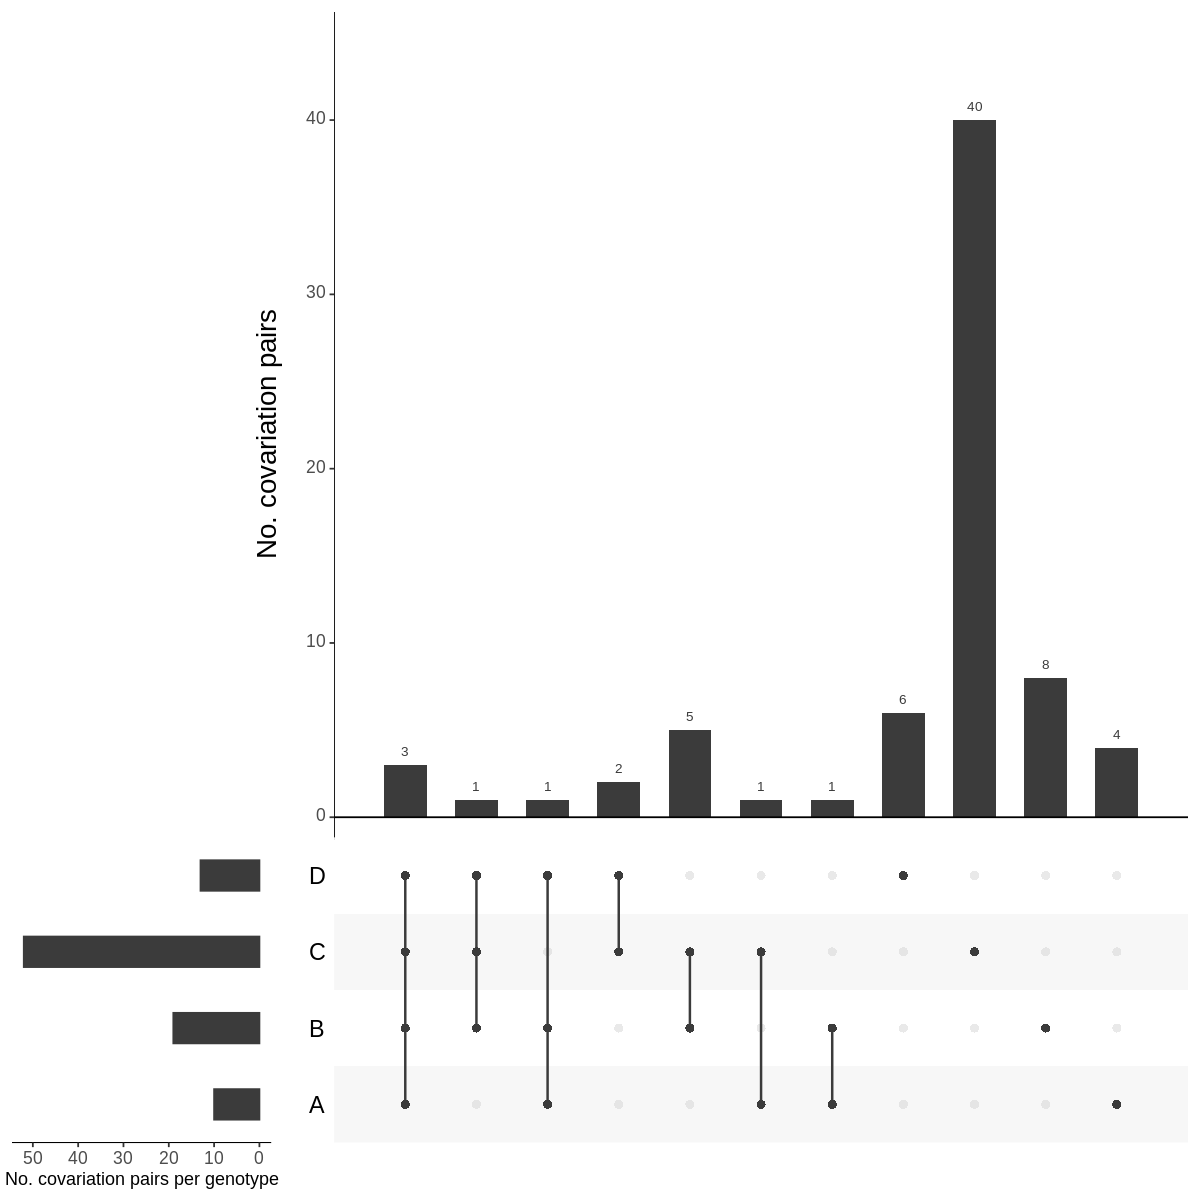

In [15]:
assocs_sig_ids <- map(assocs, function(assoc) {
    assoc_sig <- assoc[which(assoc$adj_pval < 0.05 &
                             (assoc$bs1 > 0.9 | assoc$bs2 > 0.9)), ]
    sig_ids <- assoc_sig$site_pair_id
})
options(repr.plot.width = 10, repr.plot.height = 10)
upset(fromList(assocs_sig_ids), mainbar.y.label = "No. covariation pairs", 
     sets.x.label = "No. covariation pairs per genotype",
     text.scale = c(2, 1.5, 1.3, 1.5, 2, 1.3), sets = c("A", "B", "C", "D"), 
     keep.order = T, order.by = "degree")

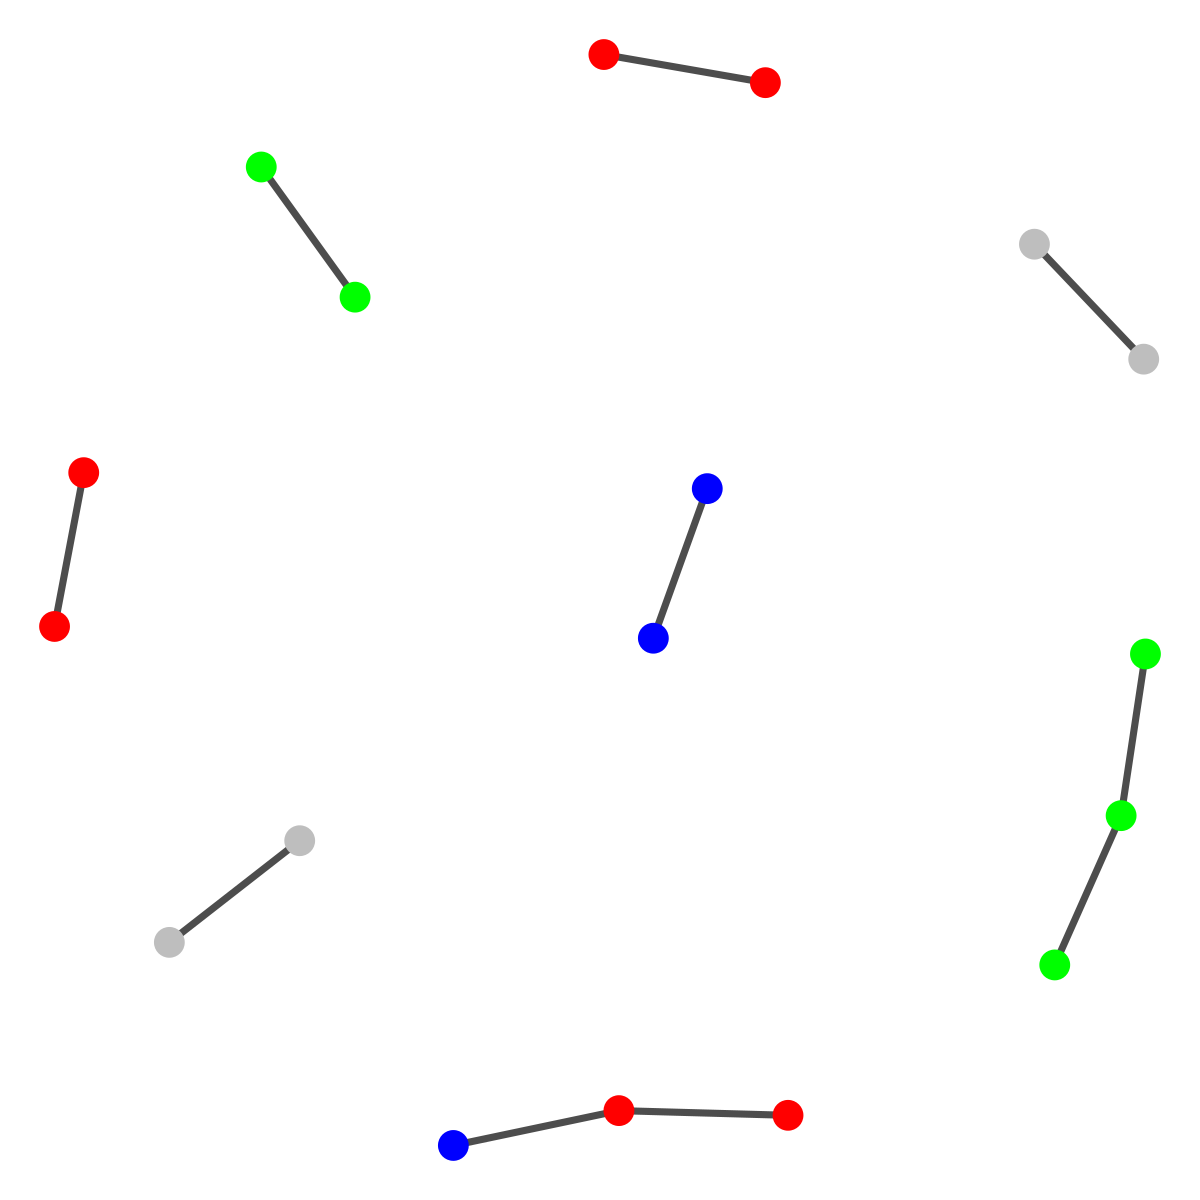

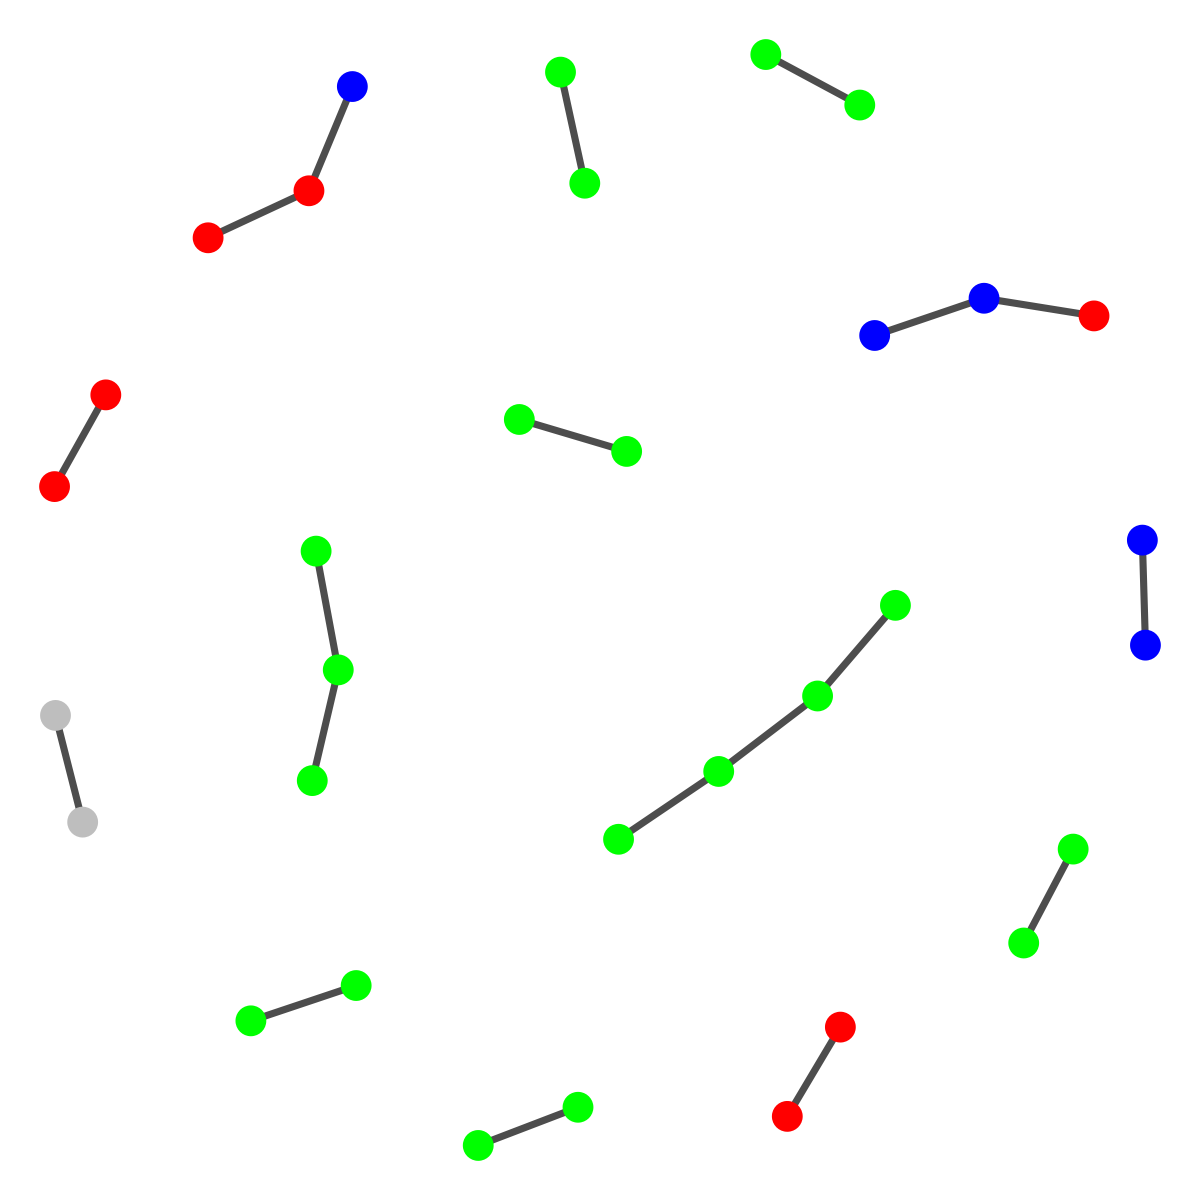

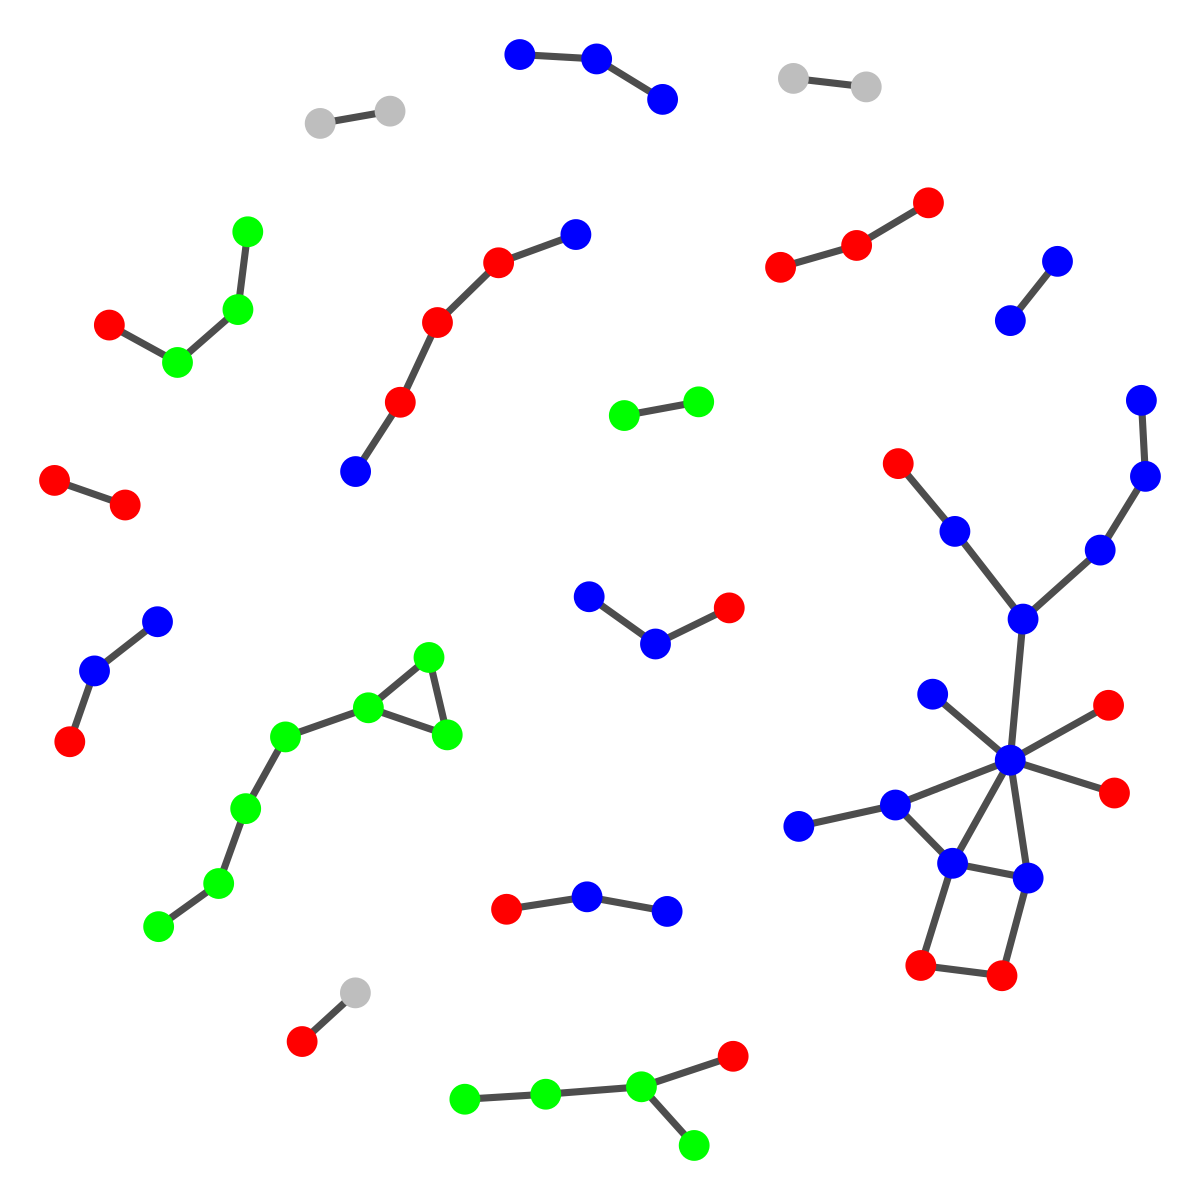

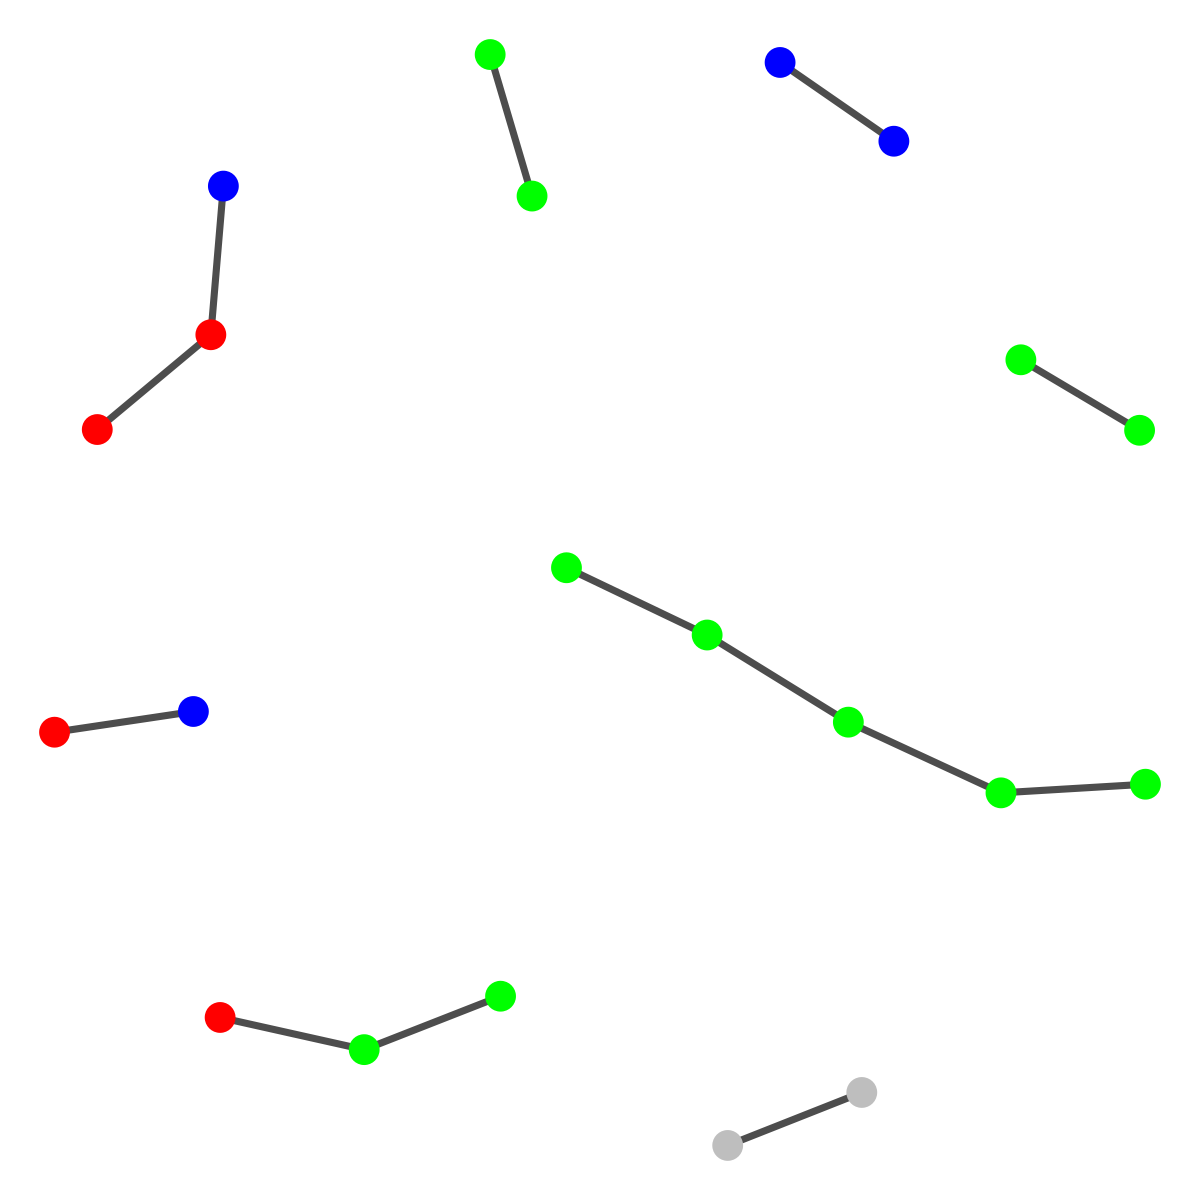

In [41]:
gene_pal <- list(
    P = "red",
    C = "green",
    S = "blue",
    X = "grey"
)
nets <- list()
for (genotype in genotypes){
    assoc <- assocs[[genotype]]
    assoc_sig <- assoc[which(assoc$adj_pval < 0.05 & 
                             assoc$potential_same_loci == 0 &
                             (assoc$bs1 > 0.9 | assoc$bs2 > 0.9)), ]
    weights <- map_dbl(1:nrow(assoc_sig), function(x) {
        max(assoc_sig$bs1[x], assoc_sig$bs2[x])
    })
    graph_data <- assoc_sig[, c("siteA", "siteB")]
    graph_data$weight <- weights
    colnames(graph_data) <- c("nodeA", "nodeB", "weight")
    nodes <- unique(c(graph_data$nodeA, graph_data$nodeB))
    node_genes <- gsub("_site.*", "", gsub("gene", "", nodes))
    node_genes_colors <- map_chr(node_genes, function(cur_gene) gene_pal[[cur_gene]])
    net <- graph_from_data_frame(graph_data, vertices = nodes, directed = F)
    nets[[genotype]] <- net
    #plot(net, vertex.size = 8, edge.width = 6, edge.color = "black",
    #     vertex.label = NA,
    #     layout = layout.graphopt, 
    #     vertex.color = node_genes_colors)
    p <- ggraph(net, layout = 'fr') + 
        geom_edge_link(edge_color = "black", alpha = 0.7, width = 2) +  # Plot edges with transparency
        geom_node_point(aes(color = node_genes_colors), size = 8) +  # Plot nodes
        scale_color_identity() +  # Use identity scale for node colors
        theme_void()  # Remove axes and background
    print(p)
}

In [53]:
color_scheme <- list(
    # Major category: X
    X = "#A9A9A9",  # Dark Grey for the category X

    # Major category: P
    terminal_protein = "#FFA07A",      # Light Salmon
    spacer = "#FF8C00",                # Dark Orange
    reverse_transcriptase = "#FFD700", # Gold
    RNAse_h = "#FFC107",               # Orange Red

    # Major category: S
    pre_s1 = "#87CEEB",                # Sky Blue
    pre_s2 = "#4682B4",                # Steel Blue
    surface_antigen = "#1E90FF",       # Dodger Blue

    # Major category: C
    pre_core = "#98FB98",              # Pale Green
    core = "#2E8B57",                  # Sea Green

    # Repeated Colors for Major Categories
    P = "#FF8C00",                     # Dark Orange for category label
    S = "#1E90FF",                     # Dodger Blue for category label
    C = "#2E8B57"                      # Sea Green for category label
)

domain_pos_file <- "./analysis/protein_domain_pos.rds"
domain_pos <- readRDS(domain_pos_file)
domain_data <- list()
cur_y <- 0.3
for (gene in names(domain_pos[[genotype]])) {
    cur_y <- cur_y + 0.5
    for (domain in names(domain_pos[[genotype]][[gene]])) {
        start <- domain_pos[[genotype]][[gene]][[domain]][1]
        end <- domain_pos[[genotype]][[gene]][[domain]][2]
        if (end < start) {
            end <- end + 3664 + 20
        }
        domain_data[[domain]] <- c(domain, cur_y, cur_y + 0.5, start, end, color_scheme[[domain]])
    }
}
domain_data <- data.frame(do.call(rbind, domain_data), stringsAsFactors = F)
colnames(domain_data) <- c("name", "y_bottom", "y_top", "start", "end", "color")
domain_data$y_bottom <- as.numeric(domain_data$y_bottom)
domain_data$y_top <- as.numeric(domain_data$y_top)
domain_data$start <- as.numeric(domain_data$start)
domain_data$end <- as.numeric(domain_data$end)

Note: 39 points are out of plotting region in sector '0', track '1'.

Note: 39 points are out of plotting region in sector '0', track '1'.



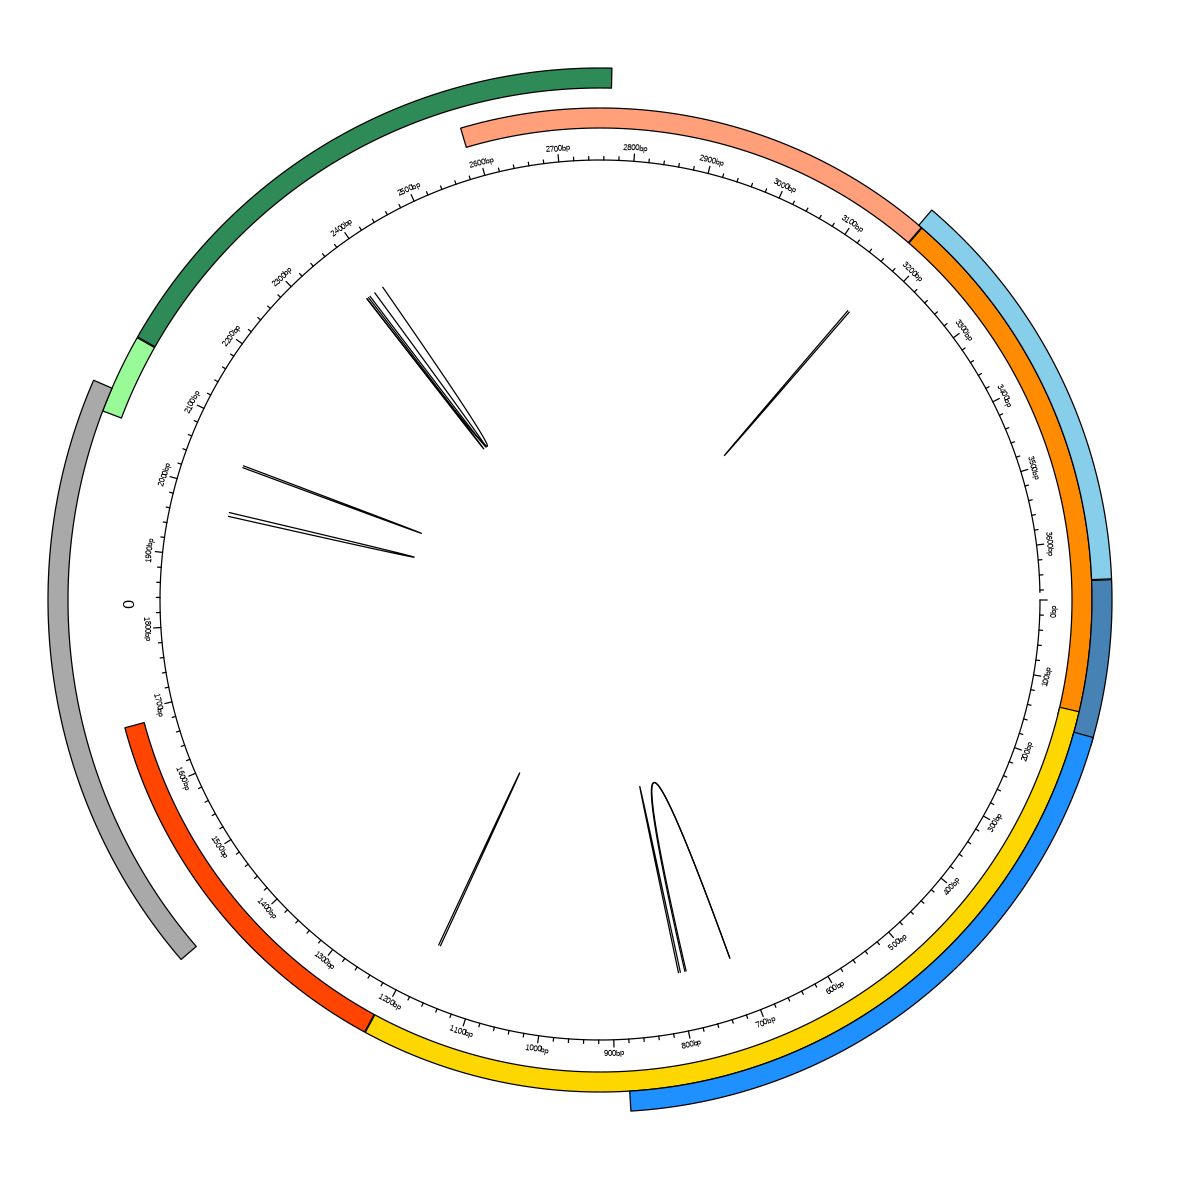

Note: 39 points are out of plotting region in sector '0', track '1'.



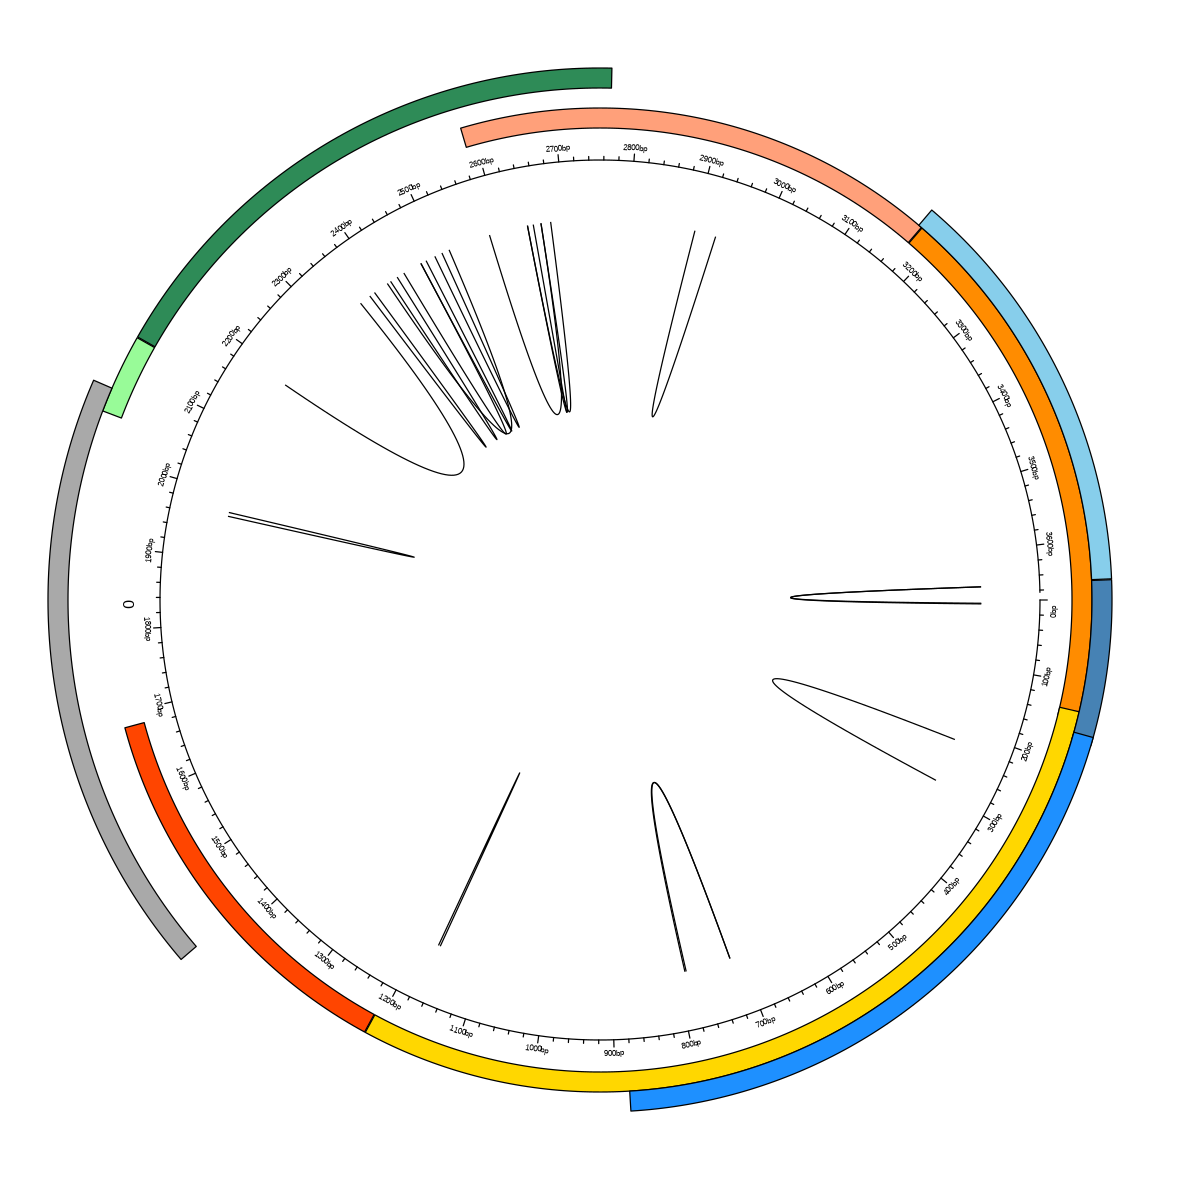

Note: 39 points are out of plotting region in sector '0', track '1'.



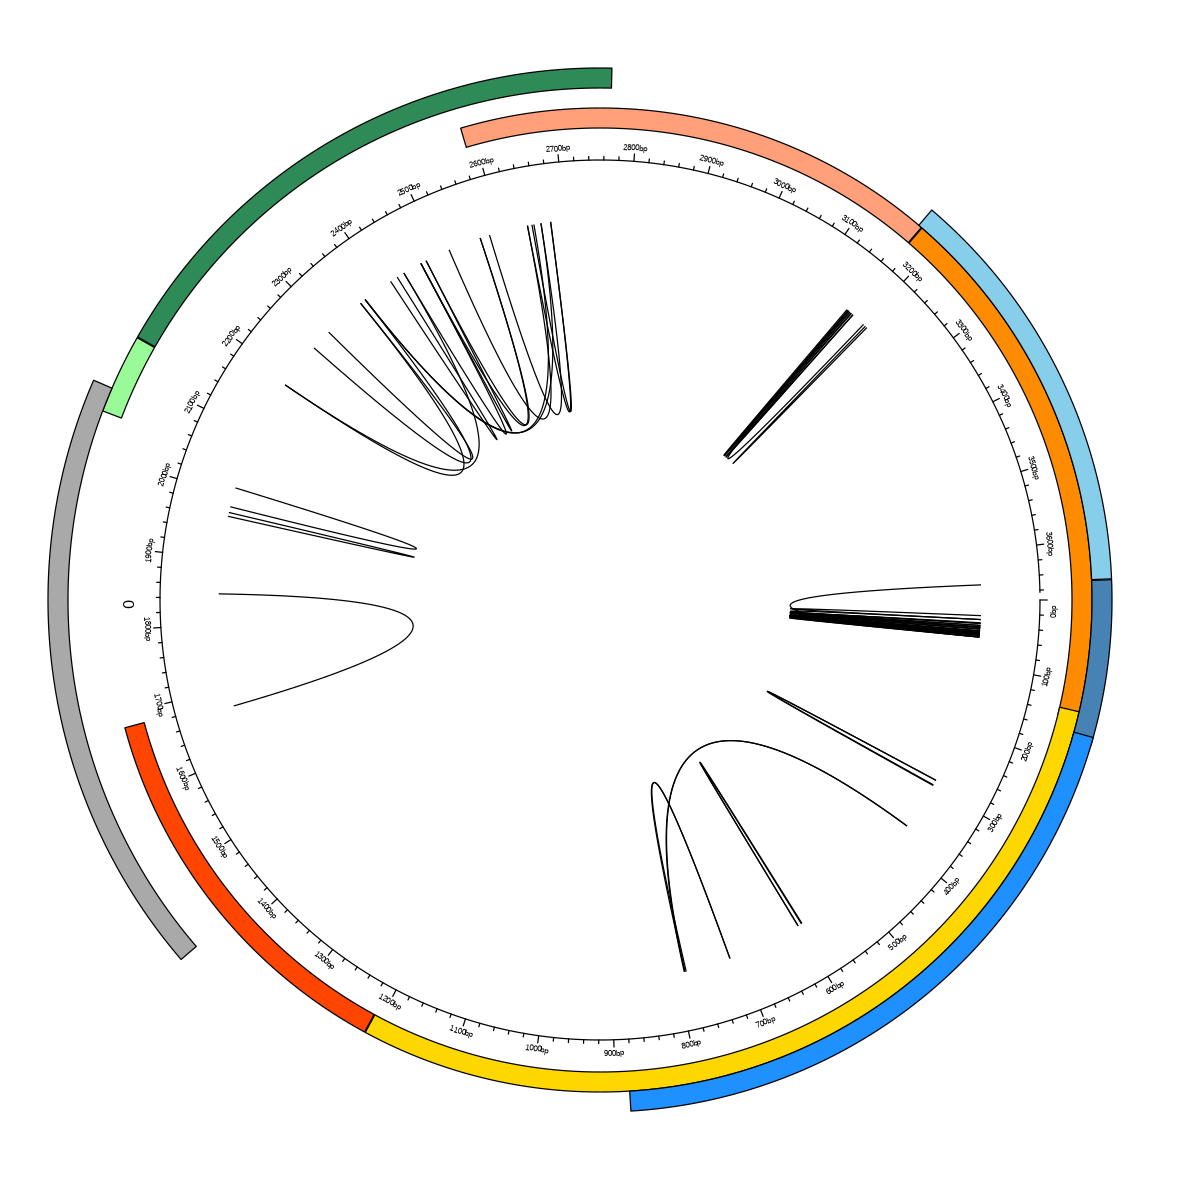

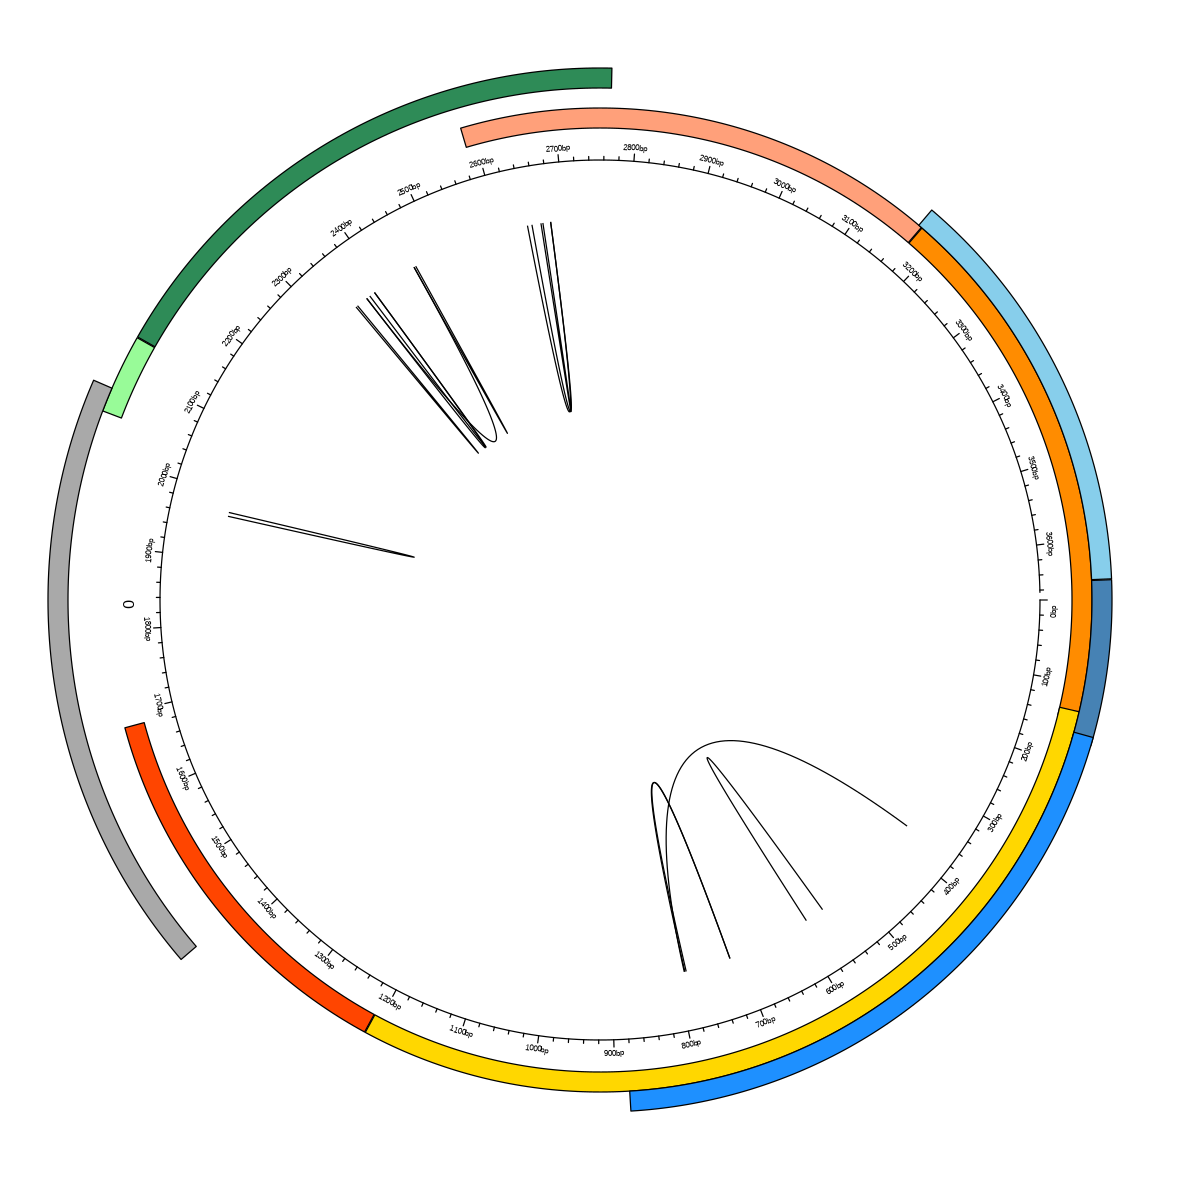

In [54]:
for (genotype in genotypes) {
    assoc <- assocs[[genotype]]
    assoc_sig <- assoc[which(assoc$adj_pval < 0.05 & assoc$potential_same_loci == 0 &
                            (assoc$bs1 > 0.9 | assoc$bs2 > 0.9)), ]

    # set up the basic circos plot
    options(repr.plot.width=10, repr.plot.height=10)
    genome_df <- data.frame(chr = '0', start = 1, end = 3664)
    circos.par(list('track.margin'=c(0.01,0.1)))
    circos.genomicInitialize(genome_df, tickLabelsStartFromZero = T, )
    circos.genomicRect(domain_data[,c("start", "end")], 'test',
                        ytop = domain_data$y_top,
                        ybottom = domain_data$y_bottom,
                        col = domain_data$color,)
    link_pos1 <- data.frame(chr = '0', 
                            start = assoc_sig$wg_start_pos1, 
                            end = assoc_sig$wg_start_pos1)
    link_pos2 <- data.frame(chr = '0', 
                            start = assoc_sig$wg_start_pos2, 
                            end = assoc_sig$wg_start_pos2)
    circos.genomicLink(region1 = link_pos1, region2 = link_pos2)
}

In [7]:
domain_pos_file <- "./analysis/protein_domain_pos.rds"

ovp_domains <- list(
    c("X", "pre_core"),
    c("X", "RNAse_h"),
    c("core", "terminal_protein"),
    c("pre_s1", "spacer"),
    c("pre_s2", "spacer"),
    c("pre_s2", "reverse_transcriptase"),
    c("surfice_antigen", "reverse_transcriptase")
)
ovp_domains <- map_chr(ovp_domains, function(x) paste(sort(c(x[1], x[2])), collapse = ":"))                  

domain_pos_wg_file <- "./analysis/protein_domain_pos.rds"
domain_pos_wg <- unlist(readRDS(domain_pos_file)[[genotype]], recursive = F)
names(domain_pos_wg) <- gsub(".\\.", "", names(domain_pos_wg))
domains <- names(domain_pos_wg)



In [8]:
plots <- list()
domain_rename <- list(
    terminal_protein="Terminal Protein",
    spacer = "Spacer",
    reverse_transcriptase = "Reverse Transcriptase",
    RNAse_h = "RNAse H",
    pre_s1 = "Pre-S1",
    pre_s2 = "Pre-S2",
    surface_antigen = "Surface Antigen",
    pre_core = "Pre-Core",
    core = "Core",
    X = "X"
)
for (genotype in genotypes){
    assoc <- assocs[[genotype]]
    assoc <- assoc[which(assoc$potential_same_loci == 0), ]
    assoc_sig_cnt <- sum(assoc$adj_pval < 0.05 & 
                         (assoc$bs1 > 0.9 | assoc$bs2 > 0.9))
    assoc_nonsig_cnt <- nrow(assoc) - assoc_sig_cnt
    sig_p <- assoc_sig_cnt/nrow(assoc)
    heat_data <- data.frame()
    for (i in 1:length(domains)) {
        for (j in 1:i) {
            cur_domain_pair <- paste(sort(c(domains[i], domains[j])), collapse = ":")
            cur_assoc <- filter(assoc, domain_pair == cur_domain_pair)
            cur_sig_cnt <- sum(cur_assoc$adj_pval < 0.05 &
                              (cur_assoc$bs1 > 0.9 | cur_assoc$bs2 > 0.9))
            cur_nonsig_cnt <- nrow(cur_assoc) - cur_sig_cnt
            fisher_t <- matrix(c(cur_sig_cnt, assoc_sig_cnt-cur_sig_cnt, 
                              cur_nonsig_cnt, assoc_nonsig_cnt-cur_nonsig_cnt), 
                               nrow = 2, ncol = 2)
            fisher_test <- fisher.test(fisher_t, alternative = "greater")
            OR = fisher_test$estimate
            pval = fisher_test$p.value
            
            is_domain_ovp <- ifelse(cur_domain_pair %in% ovp_domains, 1, 0)
            heat_data <- rbind(heat_data, c(domains[i], domains[j], pval, OR, is_domain_ovp, cur_sig_cnt))
        }
    }
    colnames(heat_data) <- c("domain1", "domain2", "p_val", "OR", "is_ovp", "sig_cnt")
    heat_data$adj_pval <- p.adjust(heat_data$p_val, method = 'bonferroni')
    for (i in 1:nrow(heat_data)){
        heat_data <- rbind(heat_data, c(heat_data[i, 2],
                                        heat_data[i, 1],
                                        heat_data[i, 3],
                                        heat_data[i, 4],
                                        heat_data[i, 5],
                                        heat_data[i, 6],
                                        heat_data[i, 7]))
    }
    heat_data$OR <- as.numeric(heat_data$OR)
    heat_data$p_val <- as.numeric(heat_data$p_val)
    heat_data$sig_cnt <- as.numeric(heat_data$sig_cnt)
    heat_data$adj_pval <- as.numeric(heat_data$adj_pval)
    heat_data$is_ovp <- as.numeric(heat_data$is_ovp)
    heat_data$is_sig <- ifelse(heat_data$adj_pval < 0.05, 1, NA)
    heat_data$domain1 <- factor(map_chr(heat_data$domain1, function(x) domain_rename[[x]]),
                                levels = map_chr(domains, function(x) domain_rename[[x]]))
    heat_data$domain2 <- factor(map_chr(heat_data$domain2, function(x) domain_rename[[x]]),
                                levels = map_chr(domains, function(x) domain_rename[[x]]))
    heat_data$r <- heat_data$sig_cnt/max(heat_data$sig_cnt) * 5
    p <- ggplot(heat_data, aes(x=domain1, y=domain2)) + 
        geom_tile(fill = "white") +
        geom_point(aes(size = sig_cnt, colour = OR)) +
        scale_size_continuous(range = c(0, 10)) +
        scale_color_gradient2(low = "navajowhite1", high = "firebrick", mid = "navajowhite1") +
        geom_point(aes(x=domain1, y=domain2, size = is_sig), shape = "*") +
        #geom_tile(data = heat_data[which(heat_data$is_ovp == 1), ], 
        #          aes(x=domain1, y=domain2),
        #          fill = "transparent", 
        #          colour = "black",
        #          size = 1) +
        theme(axis.title = element_blank(), 
              axis.text.x = element_text(angle = 30, hjust=1)) +
        ggtitle(paste0("Genotype ", genotype)) +
        labs(size = "No. covaring residues")
    
    plots[[genotype]] <- p
}

Warning message:
"Removed 108 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 108 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 102 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 108 rows containing missing values (`geom_point()`)."


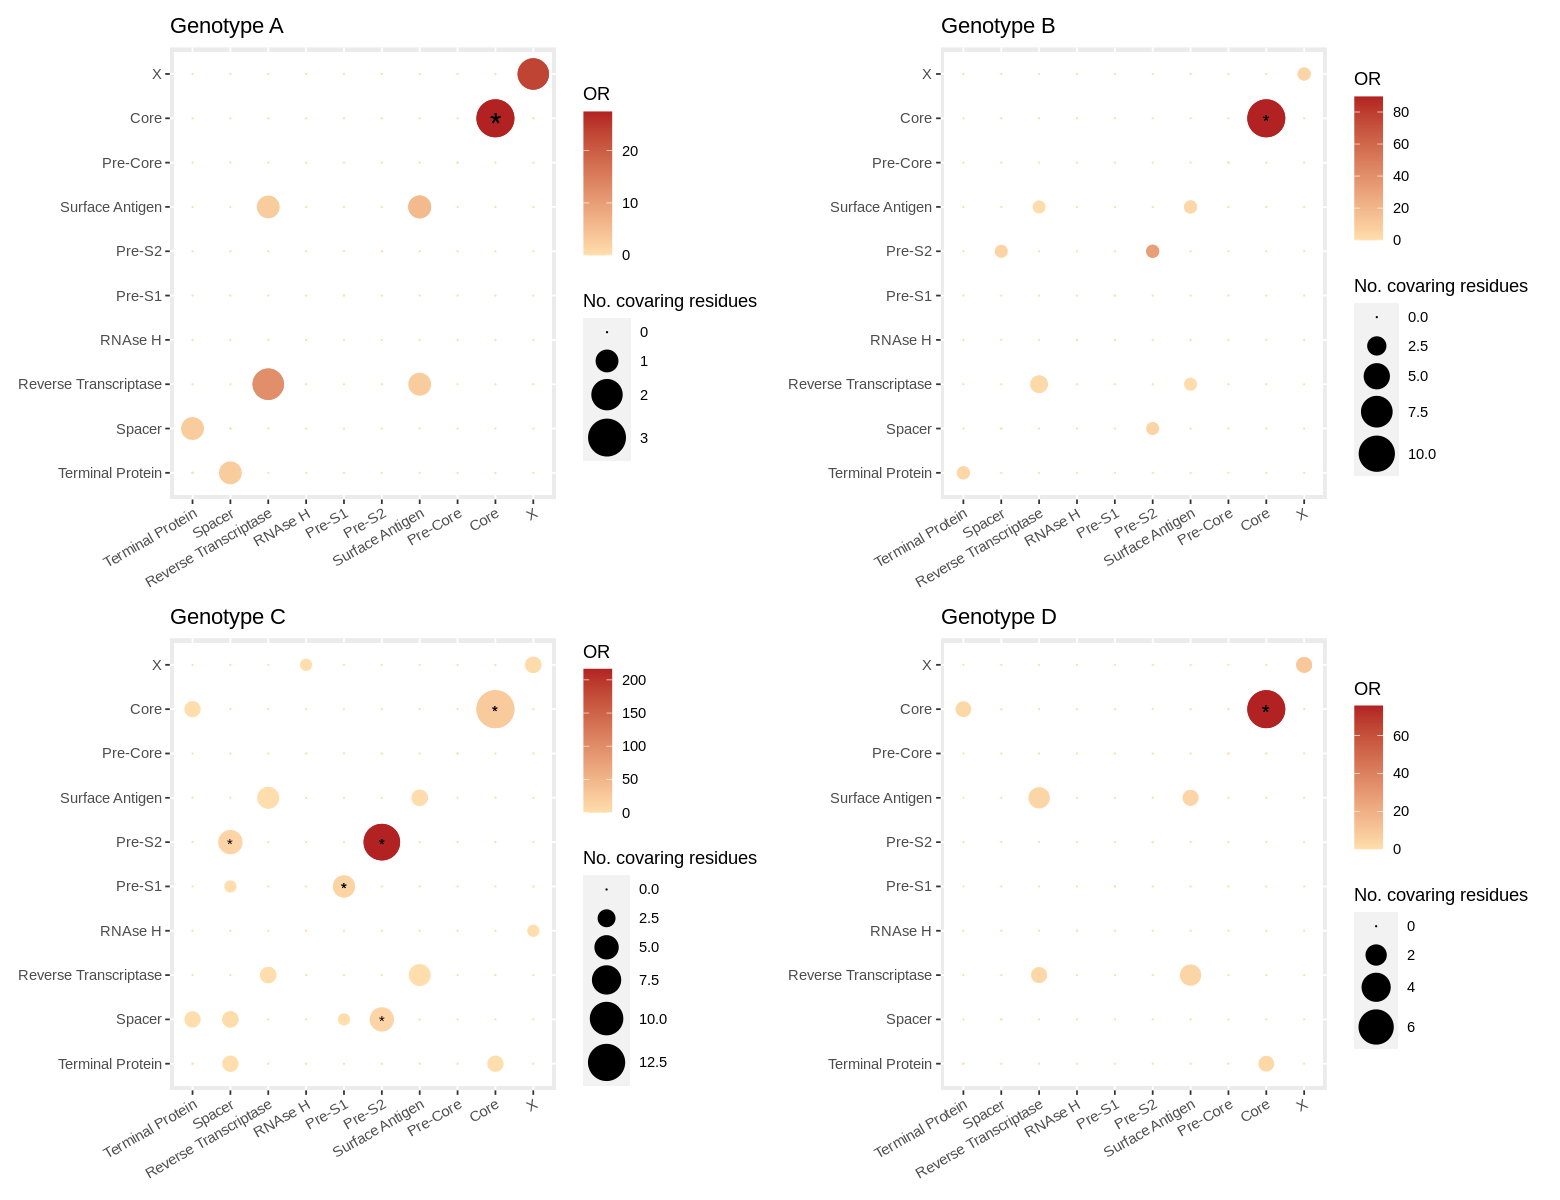

In [9]:
options(repr.plot.width = 13, repr.plot.height = 10)
myplot <- patchwork::wrap_plots(plots, nrow=2)
print(myplot)